南大os主页： http://jyywiki.cn/OS/2023/

jupyter: https://jyywiki.cn/OS/2023/build/lect3.ipynb.html

In [ ]:
如何写一段代码，直接在硬件运行，how？？
不仅是程序，整个计算机系统也是一个状态机

## 1.OS 启动过程

In [ ]:
free -m 
Firmware (负责加载操作系统)： BIOS vs UEFI

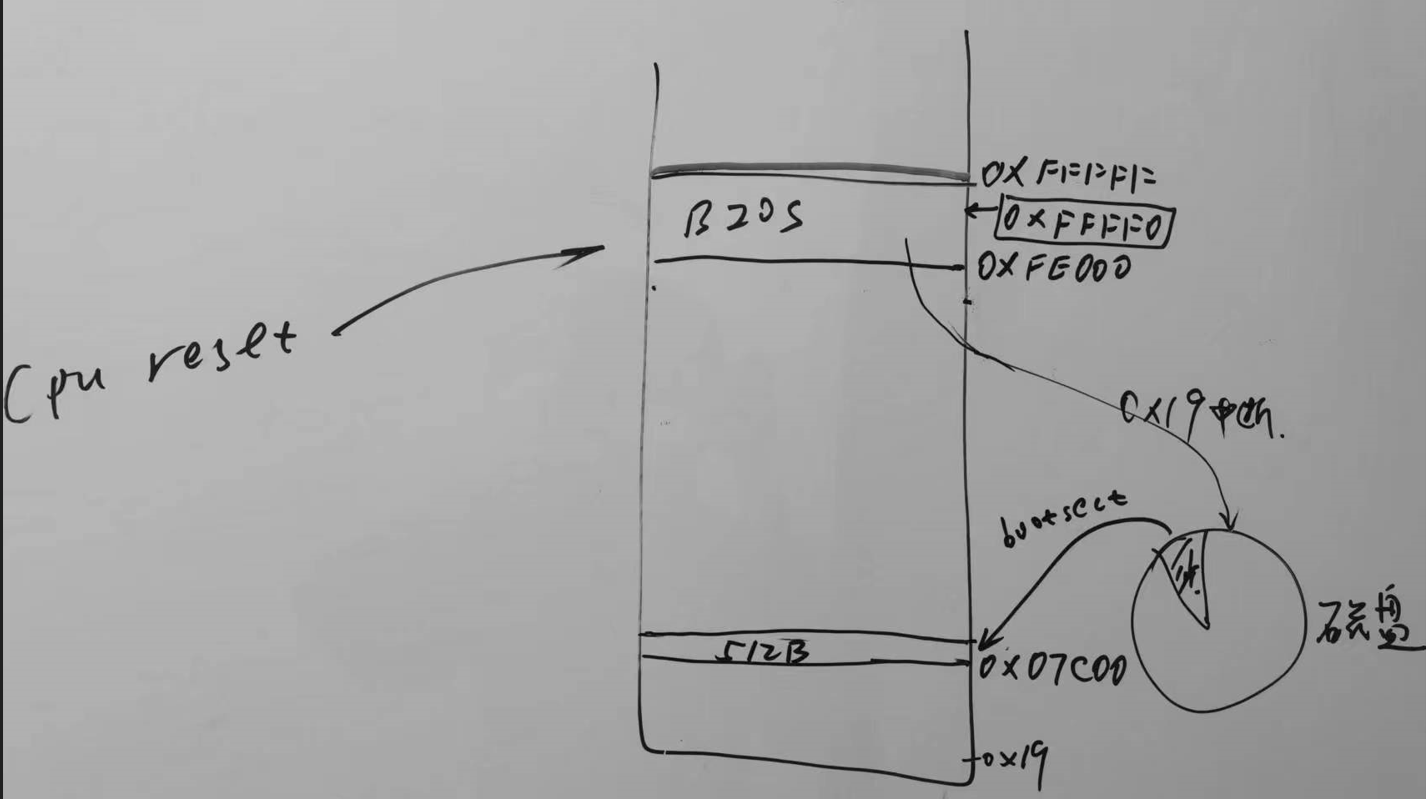

In [ ]:
主引导记录（英语：Master Boot Record，缩写：MBR），又叫做主引导扇区，
是计算机开机后访问硬盘时所必须要读取的首个扇区

## 2. CPU reset以后每一条指令的执行



In [ ]:
计算机系统公理：你想到的就一定有人做到  
有没有可能去看从CPU reset以后每一条指令的执行？
2种方法：
√  1）模拟方案：QEMU  !!!  
    2) 真机方案：JTAG (Joint Test Action Group) debugger
    一系列 (物理) 调试寄存器，可以实现 gdb 接口 (!!!)


**可引导设备的第一个512字节编译**

In [ ]:
"""
#define SECT_SIZE  512

.code16  // 16-bit assembly

// Entry of the code
.globl _start
_start:
  lea   (msg), %si   // R[si] = &msg;

again:
  movb  (%si), %al   // R[al] = *R[si]; <--+
  incw  %si          // R[si]++;           |
  orb   %al, %al     // if (!R[al])        |
  jz    done         //   goto done; --+   |
  movb  $0x0e, %ah   // R[ah] = 0x0e;  |   |
  movb  $0x00, %bh   // R[bh] = 0x00;  |   |
  int   $0x10        // bios_call();   |   |   // 跳转到 firmware
  jmp   again        // goto again; ---+---+
                     //                |
done:                //                |
  jmp   .            // goto done; <---+

// Data: const char msg[] = "...";
msg:
  .asciz "hello! !!\r\n"

// Magic number for bootable device
.org SECT_SIZE - 2
.byte 0x55, 0xAA

"""

$ make
gcc -ggdb -c mbr.S
ld mbr.o -Ttext 0x7c00
objcopy -S -O binary -j .text a.out mbr.img
$ xxd mbr.img | less  # 查看



In [ ]:
00000000: 8d36 157c 8a04 4608 c074 08b4 0eb7 00cd  .6.|..F..t......
00000010: 10eb f1eb fe68 656c 6c6f 2077 6f72 6c64  .....hello world
00000020: 2121 0d0a 0000 0000 0000 0000 0000 0000  !!..............
00000030: 0000 0000 0000 0000 0000 0000 0000 0000  ................
.....
000001e0: 0000 0000 0000 0000 0000 0000 0000 0000  ................
000001f0: 0000 0000 0000 0000 0000 0000 0000 55aa  ..............U.

In [ ]:
$ make run
qemu-system-x86_64 mbr.img
WARNING: Image format was not specified for 'mbr.img' and probing guessed raw.
         Automatically detecting the format is dangerous for raw images, write operations on block 0 will be restricted.
         Specify the 'raw' format explicitly to remove the restrictions.


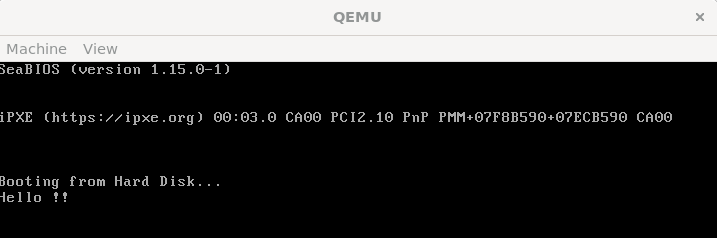

**gdb 调试 QEMU**

In [ ]:
$ man qemu-system
 -s     Shorthand for -gdb tcp::1234, i.e. open a gdbserver on TCP port 1234 (see the GDB usage chapter
              in the System Emulation Users Guide).
  -S     Do not start CPU at startup (you must type 'c' in the monitor).
$ qemu-system-x86_64 -s -S mbr.img &

$ gdb
 

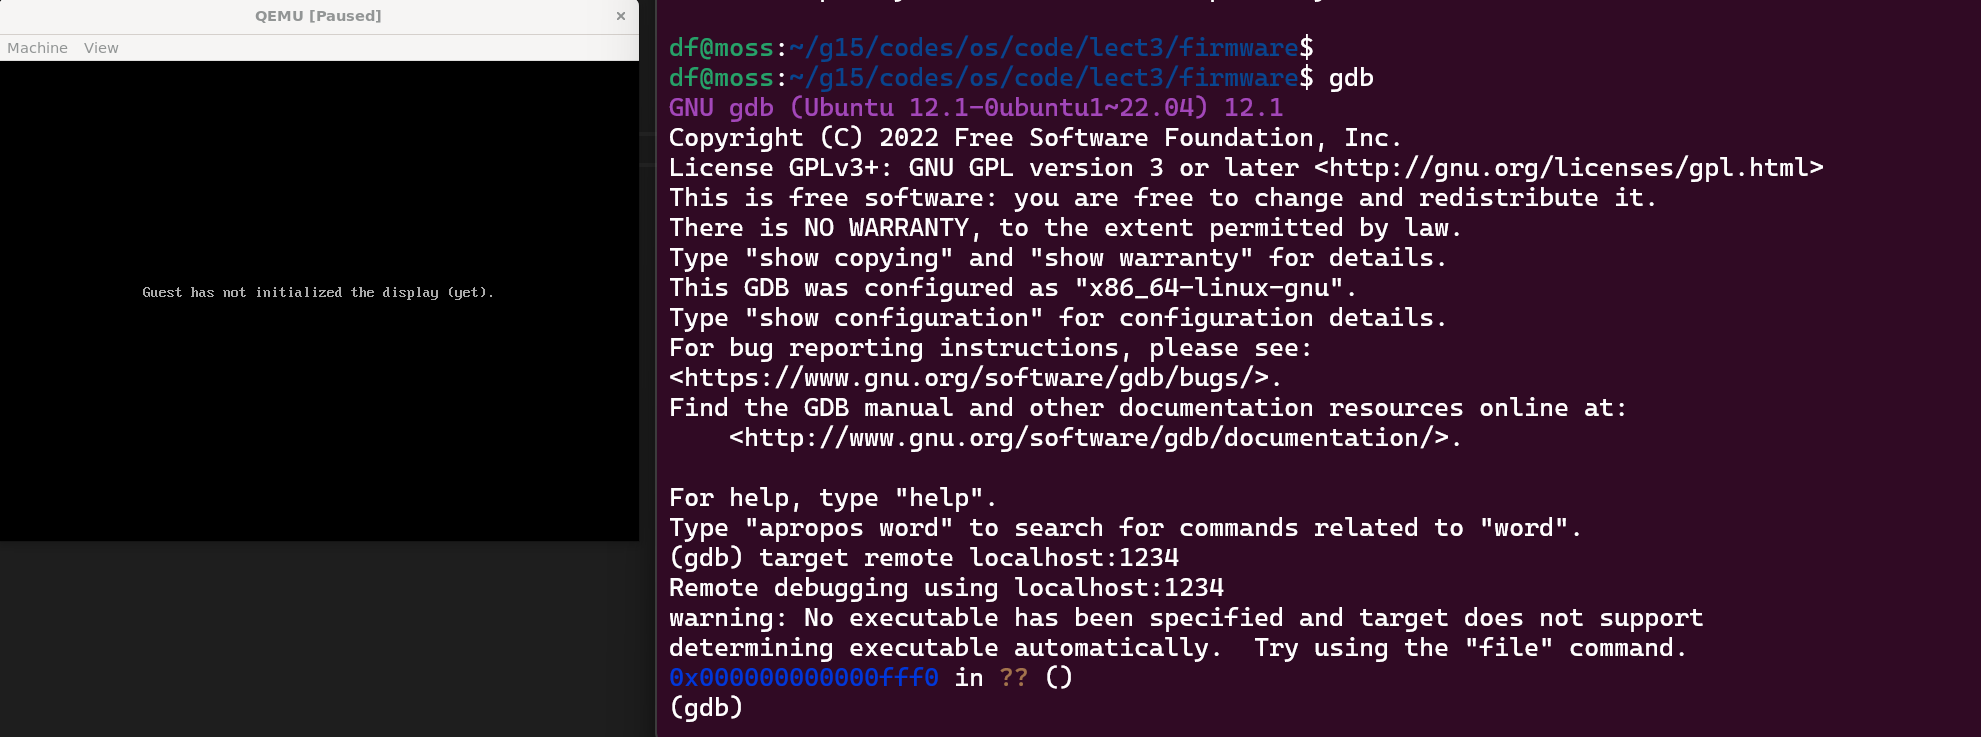

In [ ]:
(gdb) p/x $rip
$5 = 0xfff0
(gdb) p/x $cs
$6 = 0xf000
(gdb) p/x $cs *16 + $rip
$7 = 0xffff0
(gdb) x/10i $cs * 16 + $rip
   0xffff0:     (bad)
   0xffff1:     pop    %rbx
   0xffff2:     loopne 0xffff4
   0xffff4:     lock xor %dh,(%rsi)
   0xffff7:     (bad)
   0xffff8:     xor    (%rbx),%dh
   0xffffa:     (bad)
   0xffffb:     cmp    %edi,(%rcx)
   0xffffd:     add    %bh,%ah
   0xfffff:     add    %al,(%rax)
(gdb) x/10x $cs * 16 + $rip
0xffff0:        0x00e05bea      0x2f3630f0      0x392f3332      0x00fc0039
0x100000:       0x00000000      0x00000000      0x00000000      0x00000000
0x100010:       0x00000000      0x00000000
(gdb) si       # 单步执行
0x000000000000e05b in ?? ()
(gdb) x/10i $cs * 16 + $rip
   0xfe05b:     cs cmpw $0xffc8,(%rsi)
   0xfe060:     (bad)
   0xfe061:     add    %cl,(%rdi)
   0xfe063:     test   %ecx,-0x10(%rax)
   0xfe066:     xor    %edx,%edx
   0xfe068:     mov    %edx,%ss
   0xfe06a:     mov    $0x7000,%sp
   0xfe06e:     add    %al,(%rax)
   0xfe070:     mov    $0xfc1c,%dx
   0xfe074:     (bad)
(gdb) p/x $cs *16 + $rip   #p/x：使用十六进制打印变量；p/c 当字符打印。

$8 = 0xfe05b
(gdb) b *0x7c00
Breakpoint 1 at 0x7c00
(gdb) c
Continuing.

Breakpoint 1, 0x0000000000007c00 in ?? ()
(gdb)


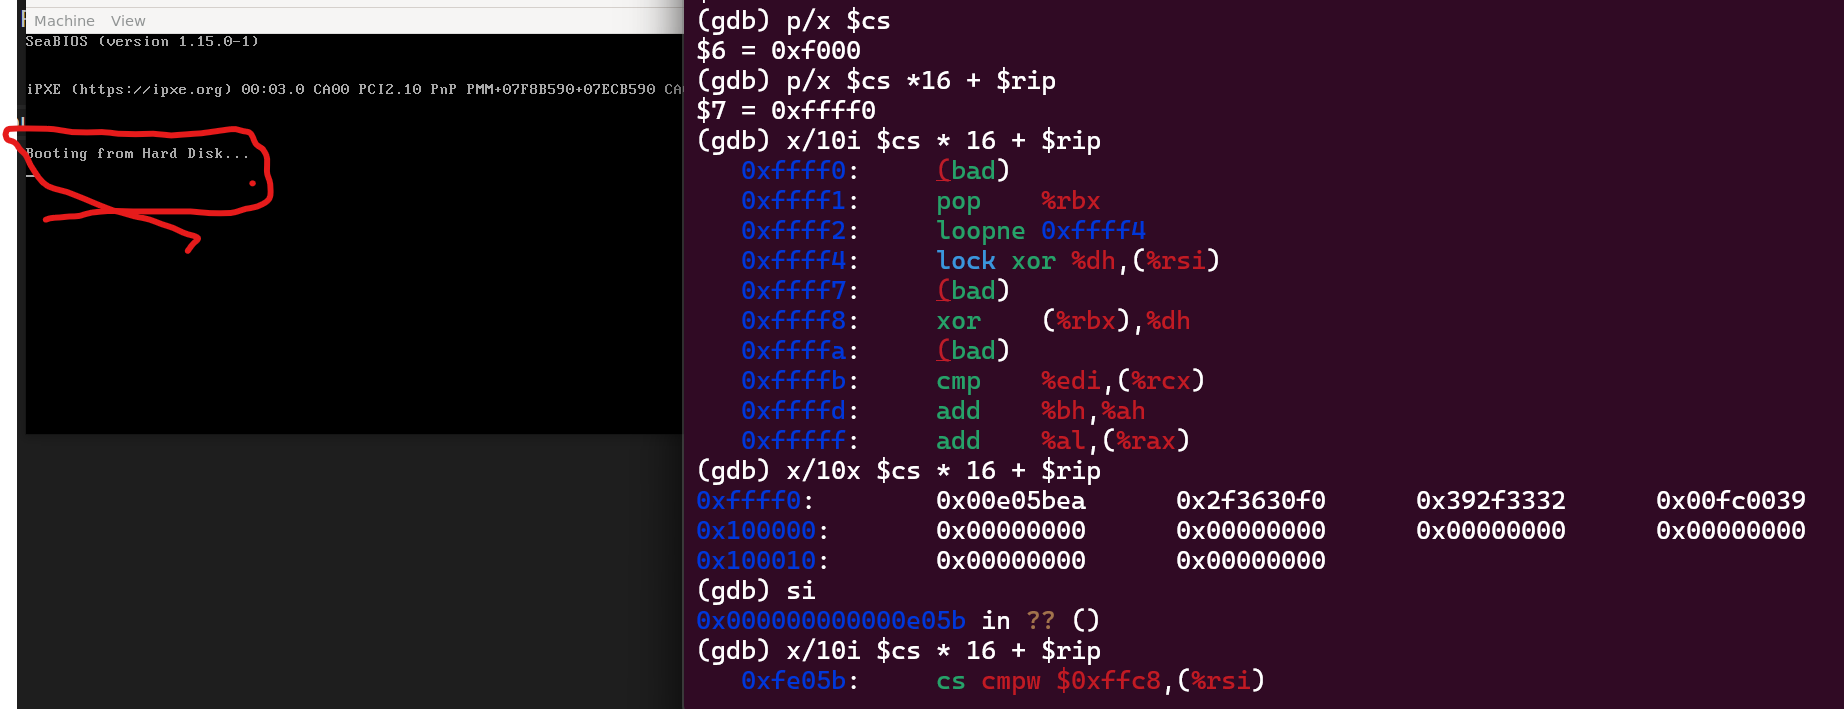

### gdb debug 技巧

In [ ]:

debug: mbr.img
	qemu-system-x86_64 -s -S $< &  # Run QEMU in background
	gdb -x init.gdb  # RTFM: gdb (1)

init.gdb：
"""
# Kill process (QEMU) on gdb exits
define hook-quit
  kill
end

# Connect to remote
target remote localhost:1234
file a.out
# wa *0x7c00
break *0x7c00
layout src
continue

"""



In [ ]:
make debug 后可以自动停在想要的地方
比如，下面18 处打断点，执行完17 后，可以看到 打印处 ‘h’
gdb q 退出

In [ ]:
x/10x 0x7c00

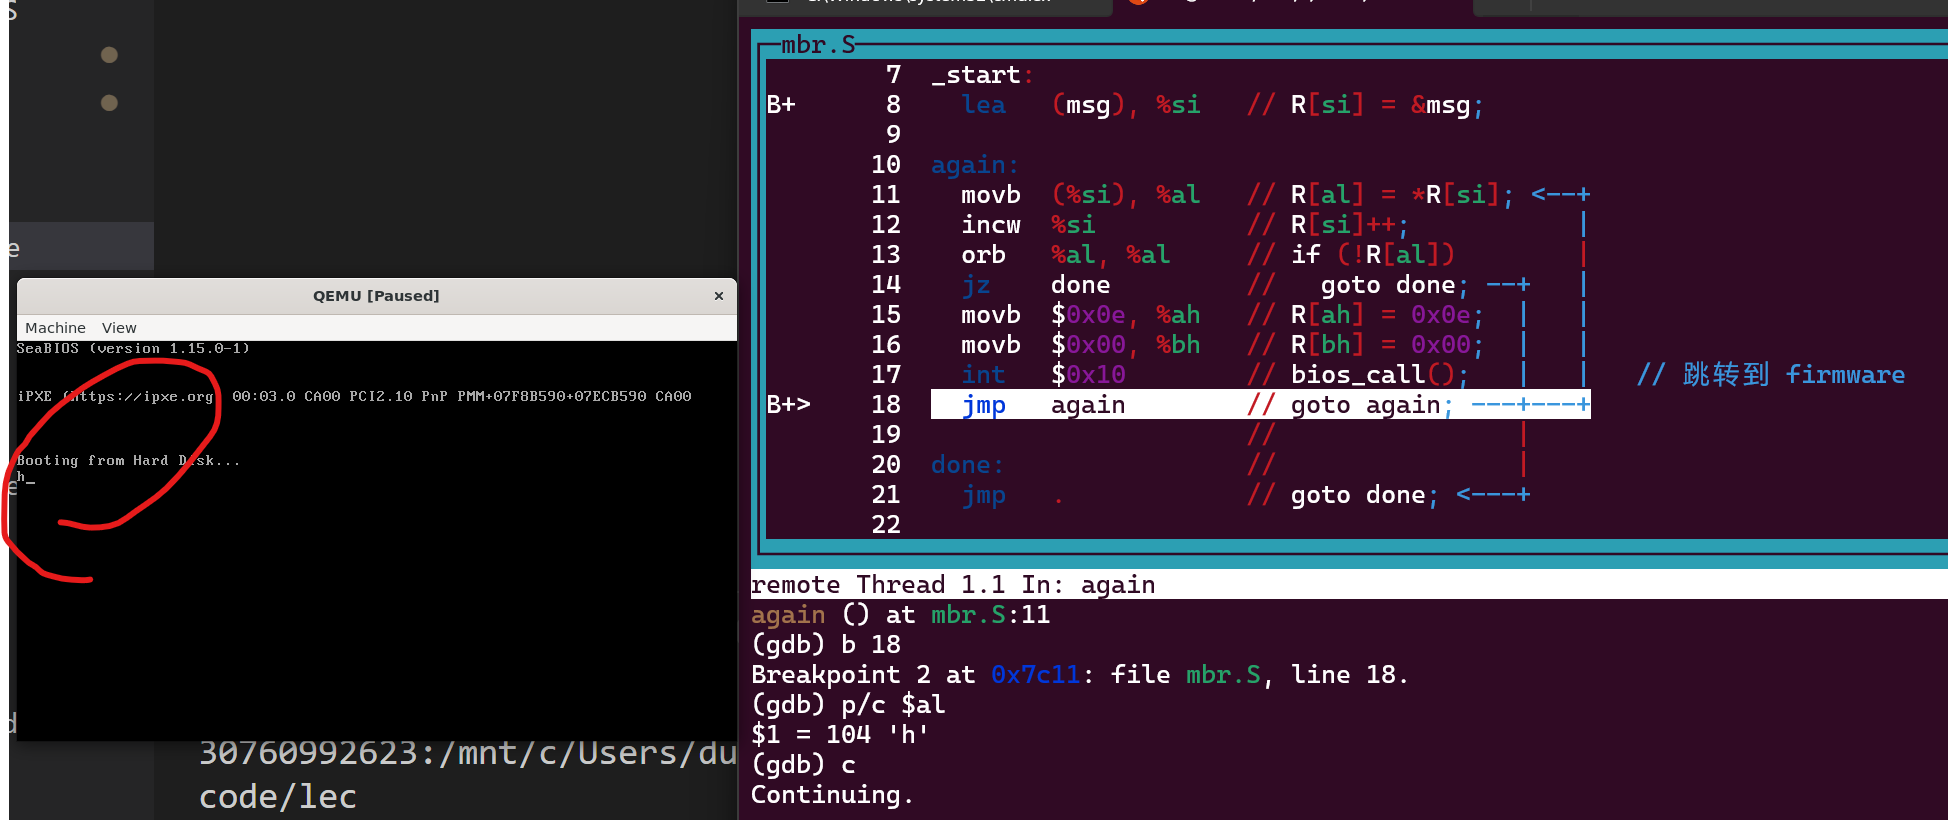

### watch point 使用 !!

In [ ]:
另一个问题，0x7c00 是谁加载的？？
使用 watch point 
可以知道内存是谁改的

"
......
target remote localhost:1234
file a.out
wa *0x7c00  <----------------
break *0x7c00
layout src
continue

"




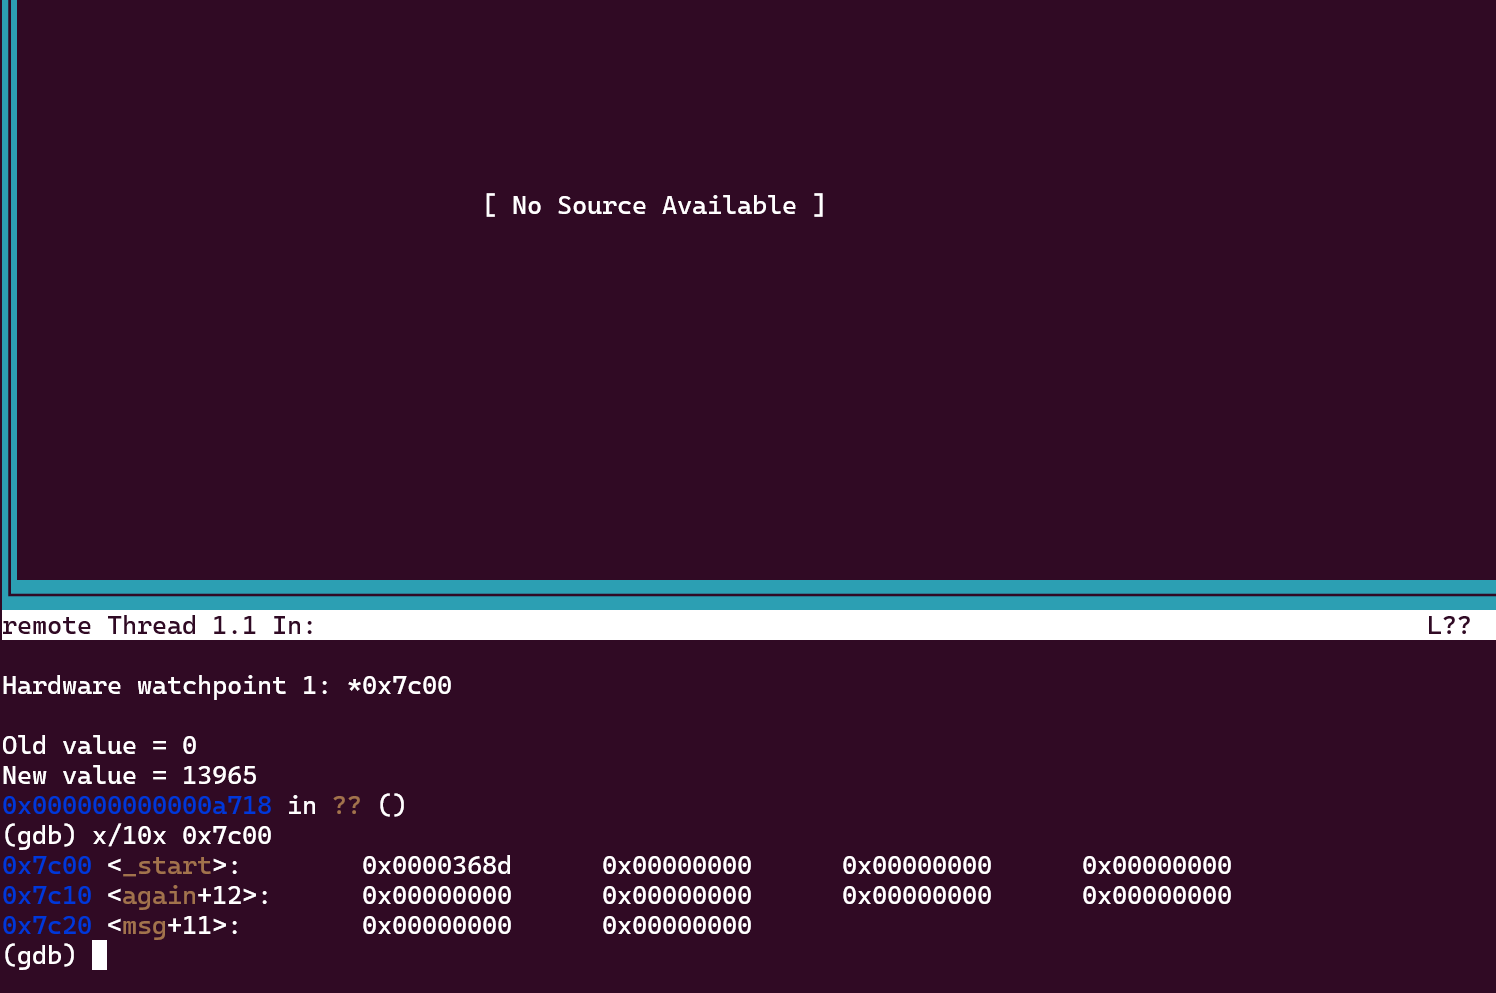

单步执行几步后，内存值变多了,也就是说 **停留在了firmware 中 **：

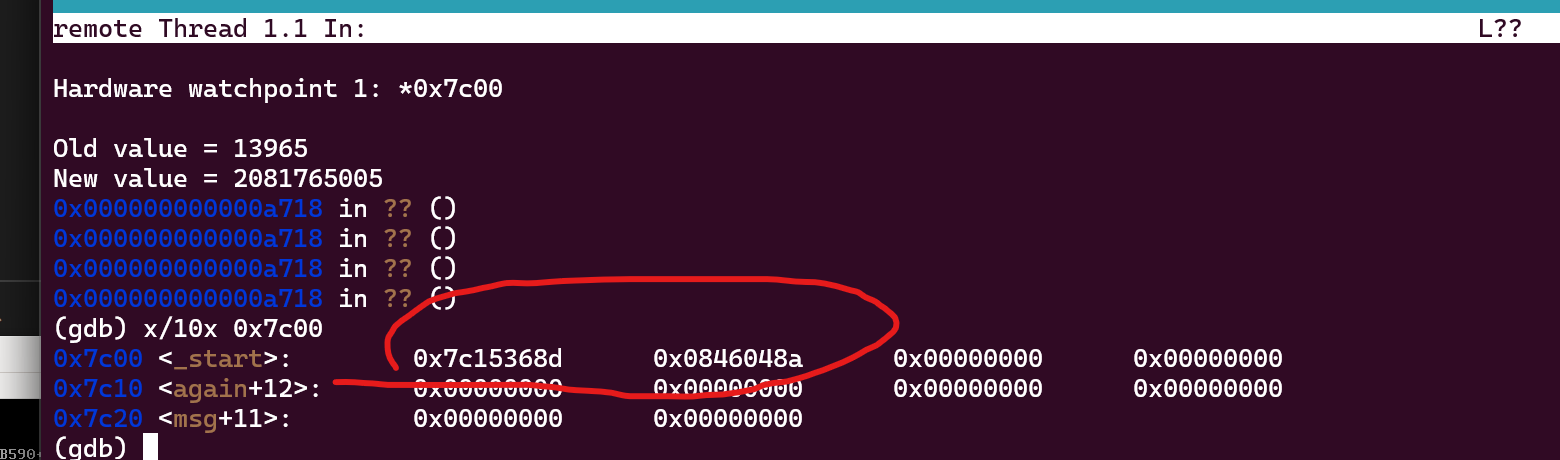

##  3.操作系统就是一个C 程序

In [ ]:
$ make -nB #将命令打印出来，但不执行
$ make -nB | vim -A 

In [ ]:
#include <am.h>
#include <klib.h>
#include <klib-macros.h>

typedef union task {
  struct {
    const char *name;
    union task *next;
    void      (*entry)(void *);
    Context    *context;
  };
  uint8_t stack[8192];
} Task;

Task *current;

void func(void *arg) {
  while (1) {
    putch(*(char *)arg);
    for (int volatile i = 0; i < 100000; i++) ;
  }
}

Task tasks[] = {
  { .name = "a", .entry = func },
  { .name = "b", .entry = func },
};

Context *on_interrupt(Event ev, Context *ctx) {
  if (!current) {
    current = &tasks[0];
  } else {
    current->context = ctx;
  }
  return (current = current->next)->context;
}

int main() {
  cte_init(on_interrupt);  // call on_interrupt() on traps/interrupts

  for (int i = 0; i < LENGTH(tasks); i++) {
    Task *task    = &tasks[i];
    Area stack    = (Area) { &task->context + 1, task + 1 };
    task->context = kcontext(stack, task->entry, (void *)task->name);
    task->next    = &tasks[(i + 1) % LENGTH(tasks)];
  }
  iset(true);  // Enable external interrupts (timer, I/O, ...)
  yield();  // Trap
}